# Ансамбли моделей машинного обучения.

В качестве набора данных используется набор данных по раку груди висконсин (диагностический)
Файл содержит следующие колонки:

- радиус (среднее расстояние от центра до точек по периметру)
- текстура (стандартное отклонение значений шкалы серого)
- периметр
- область
- гладкость (локальное изменение длины радиуса)
- компактность (периметр ^ 2 / площадь - 1.0)
- вогнутость (выраженность вогнутых участков контура)
- вогнутые точки (количество вогнутых участков контура)
- симметрия
- фрактальная размерность («приближение береговой линии» - 1)

Классы:
- WDBC-злокачественный
- WDBC-доброкачественный

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_breast_cancer, load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz 
import pydotplus
from io import StringIO 
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline 
sns.set(style="ticks")

In [2]:
breast = load_breast_cancer()

In [3]:
df_breast = pd.DataFrame(breast.data,columns=breast.feature_names)
df_breast['target'] = pd.Series(breast.target)
df_breast.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
# Значения и наименования значений целевого признака
list(zip(np.unique(breast.target), breast.target_names))

[(0, 'malignant'), (1, 'benign')]

<AxesSubplot:>

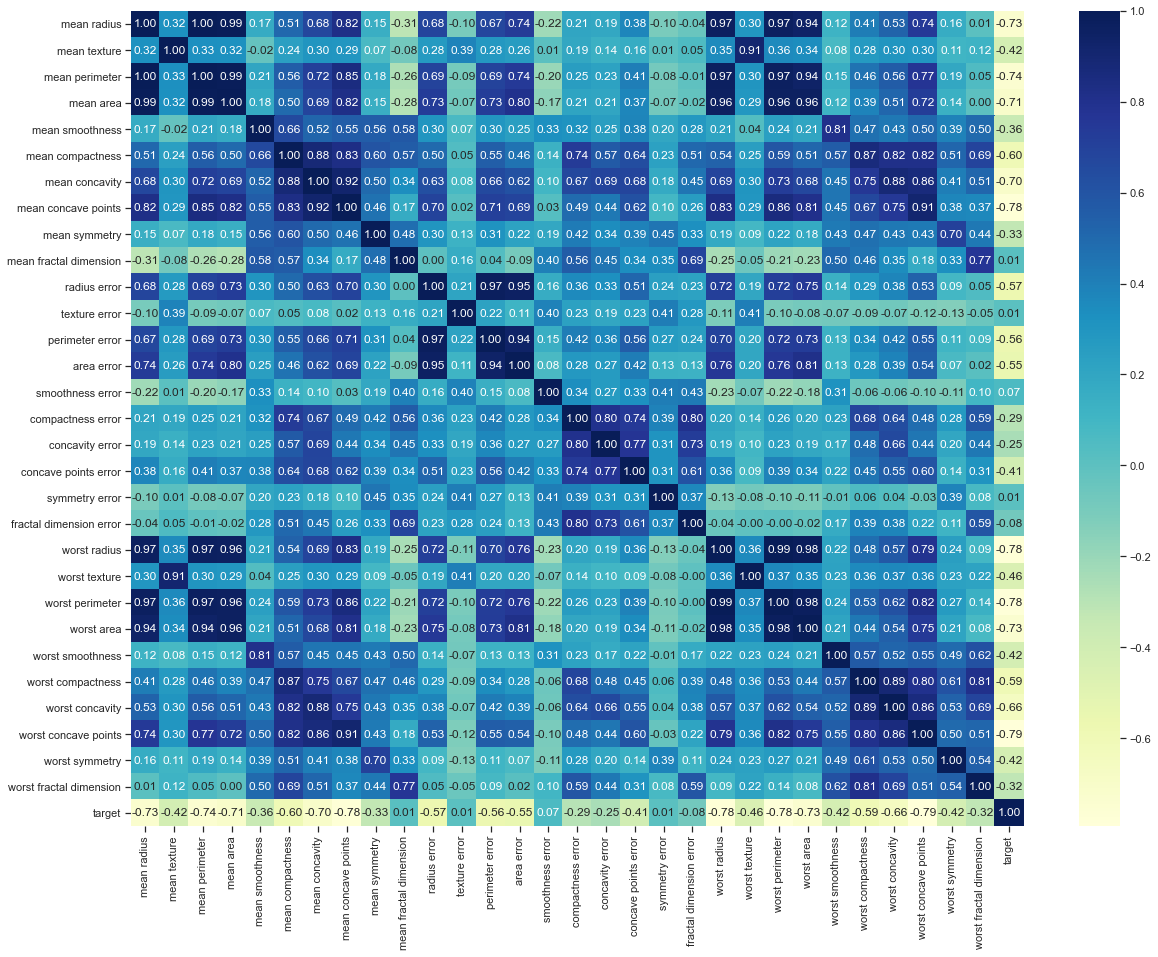

In [5]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df_breast.corr(method='pearson'), ax=ax, annot=True, fmt='.2f', cmap="YlGnBu")

In [6]:
breast_X_train, breast_X_test, breast_y_train, breast_y_test = train_test_split(
    breast.data, breast.target, test_size=0.5, random_state=1)
breast_X_train.shape, breast_X_test.shape, breast_y_train.shape, breast_y_test.shape

((284, 30), (285, 30), (284,), (285,))

In [7]:
breast_X_a = df_breast['worst radius'].values
breast_X_b = df_breast['worst texture'].values
breast_X = np.column_stack((breast_X_a, breast_X_b))
breast_y = breast.target

In [8]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf):
    title = clf.__repr__
    clf.fit(breast_X, breast_y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = breast_X[:, 0], breast_X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=breast_y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('worst radius')
    ax.set_ylabel('worst texture')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

In [9]:
from operator import itemgetter

def draw_feature_importances(tree_model, X_dataset, figsize=(10,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

## Случайный лес и сверхслучайные деревья

In [10]:
# Обучим классификатор на 5 деревьях
tree1 = RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)
tree1.fit(breast_X, breast_y)

C:\Users\kenia\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\kenia\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


RandomForestClassifier(n_estimators=5, oob_score=True, random_state=10)

In [11]:
# Out-of-bag error, возвращаемый классификатором
tree1.oob_score_, 1-tree1.oob_score_

(0.8347978910369068, 0.16520210896309317)

In [12]:
tree1.oob_decision_function_[55:70]

array([[nan, nan],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [nan, nan],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

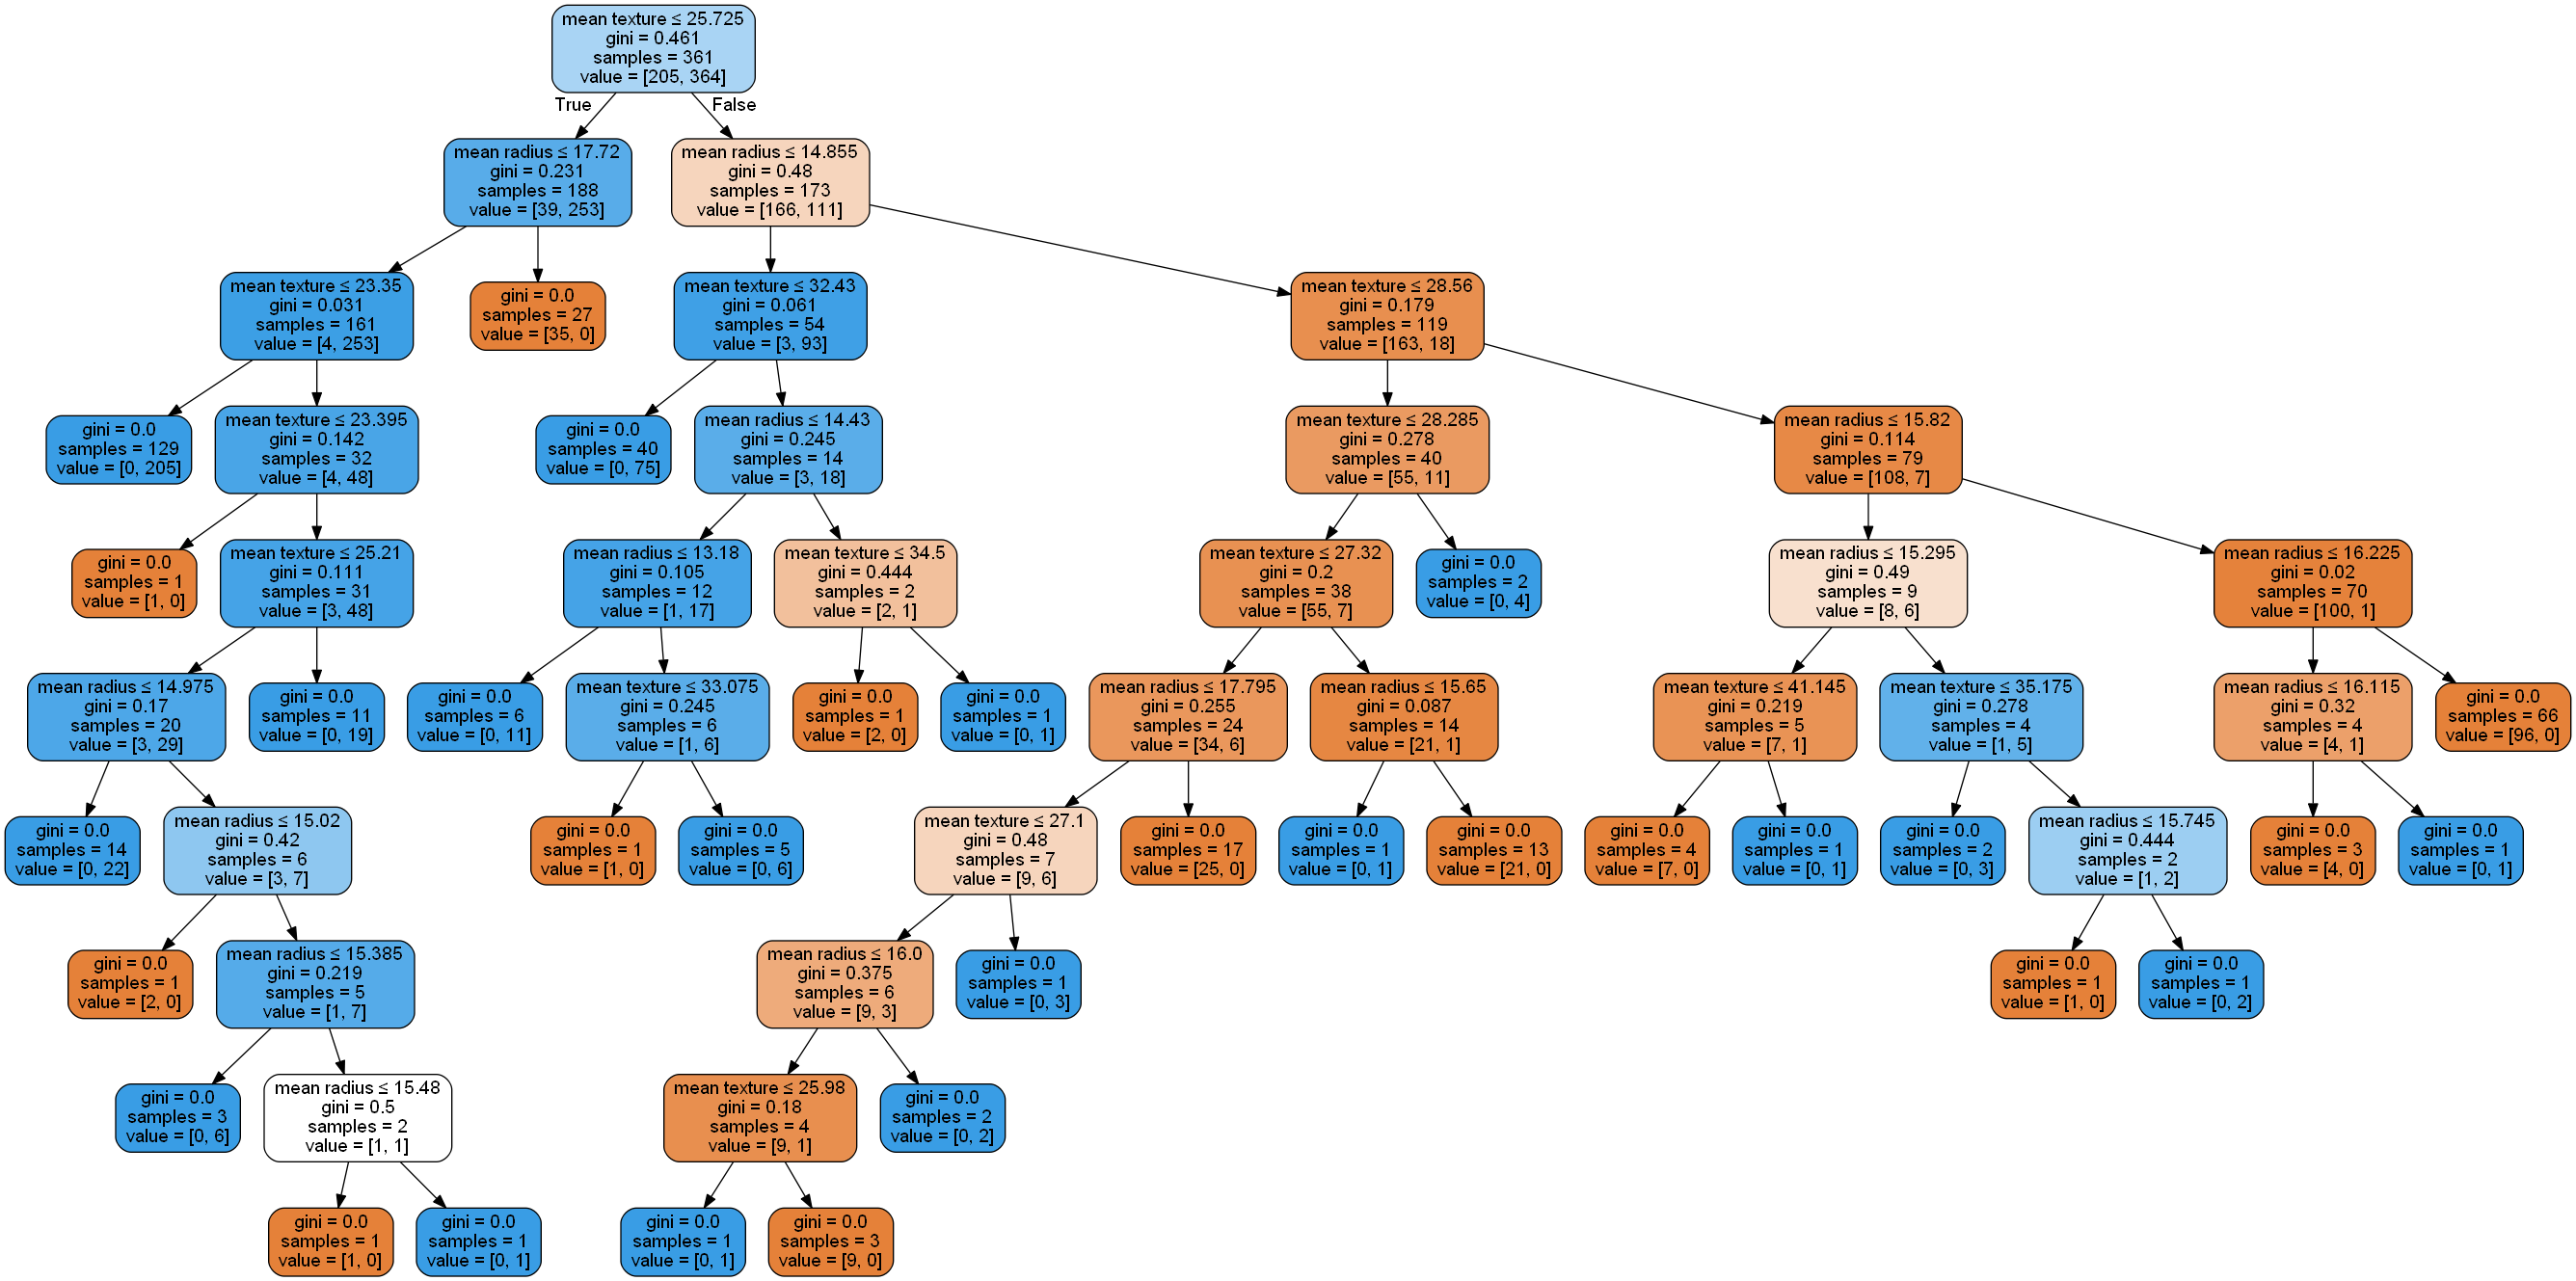

In [13]:
Image(get_png_tree(tree1.estimators_[0], breast.feature_names[:2]), width="1000")

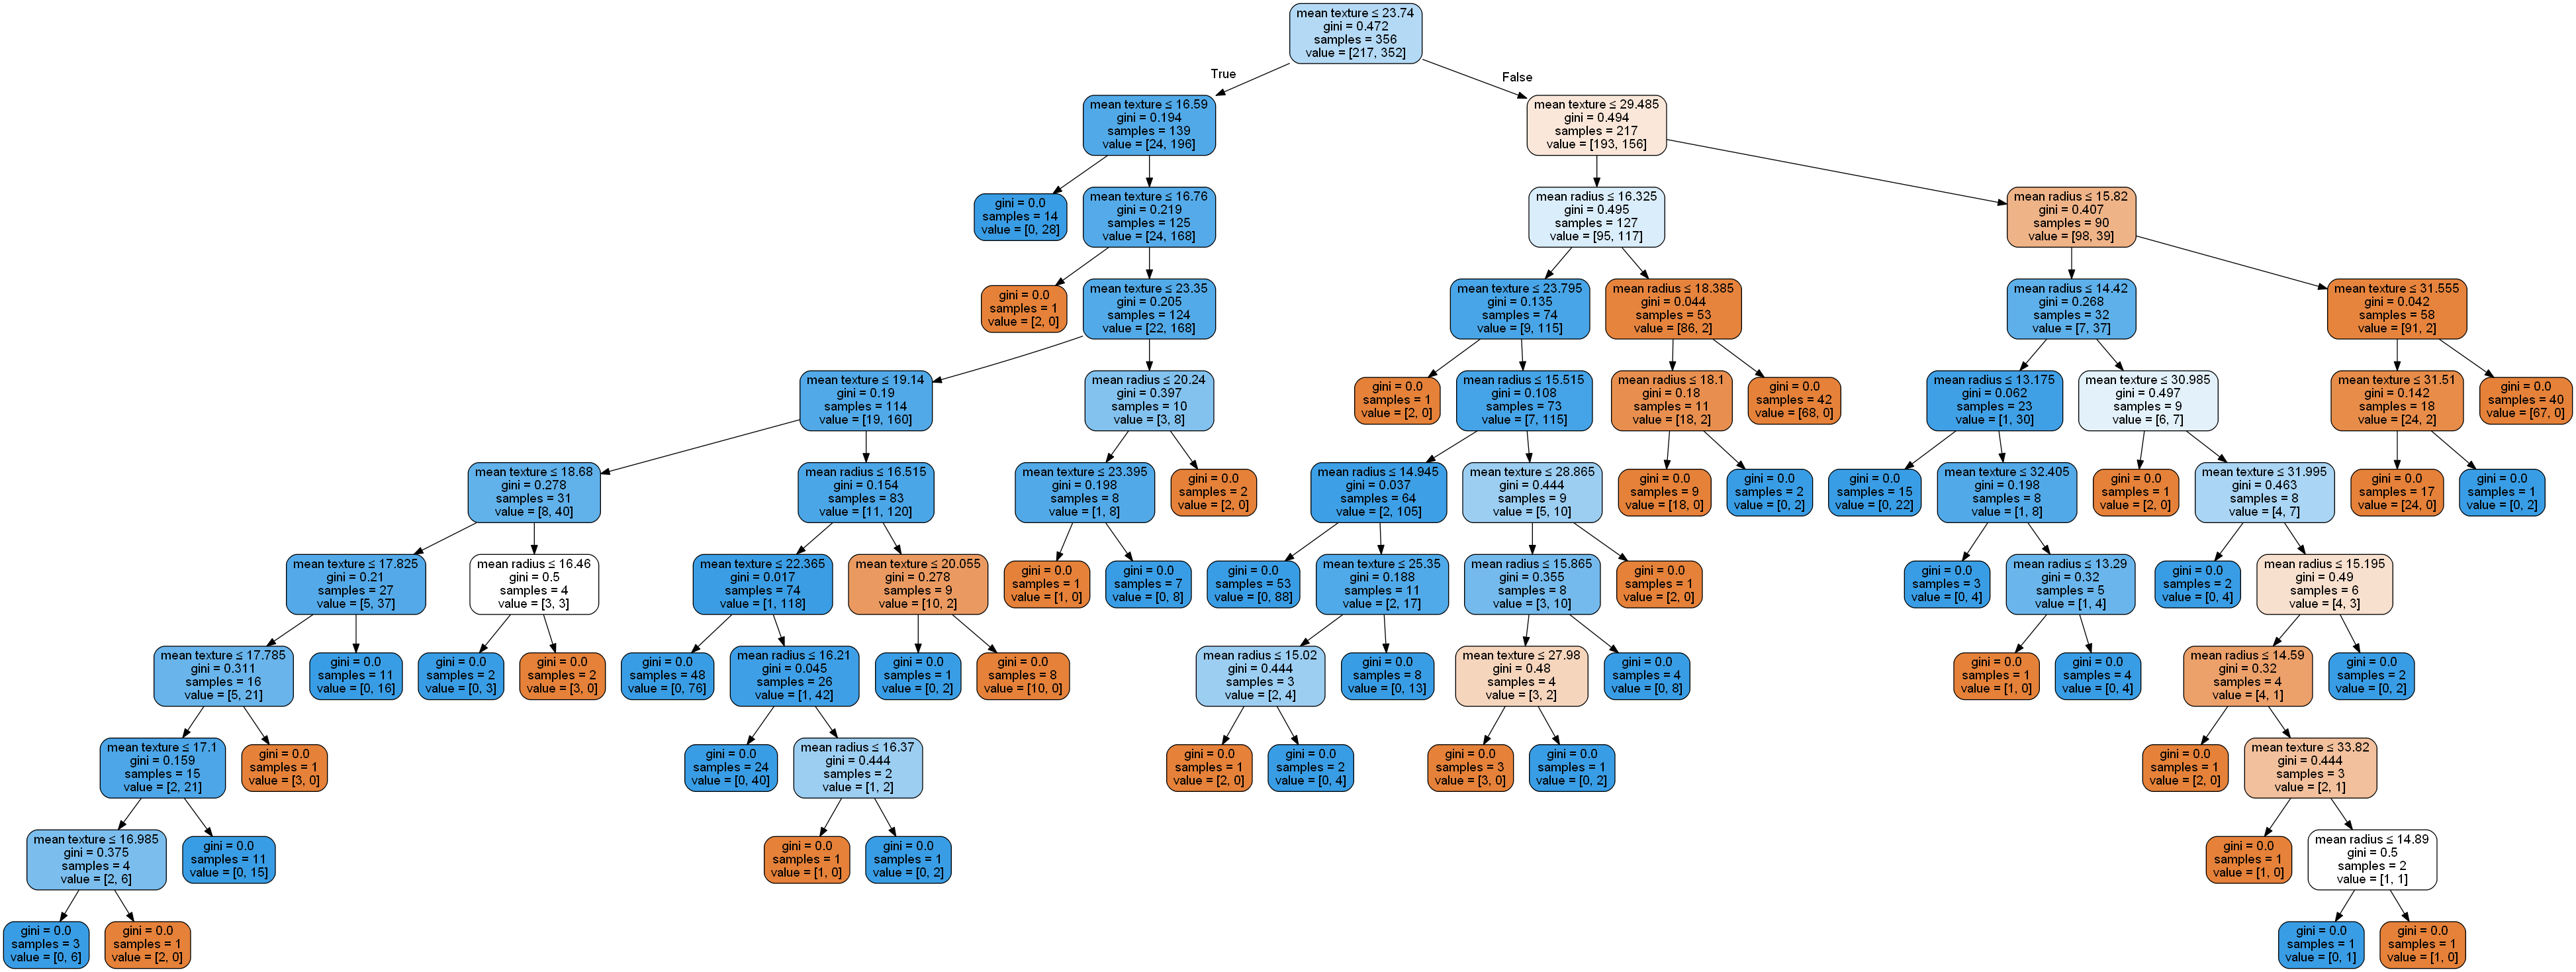

In [14]:
Image(get_png_tree(tree1.estimators_[1], breast.feature_names[:2]), width="1000")

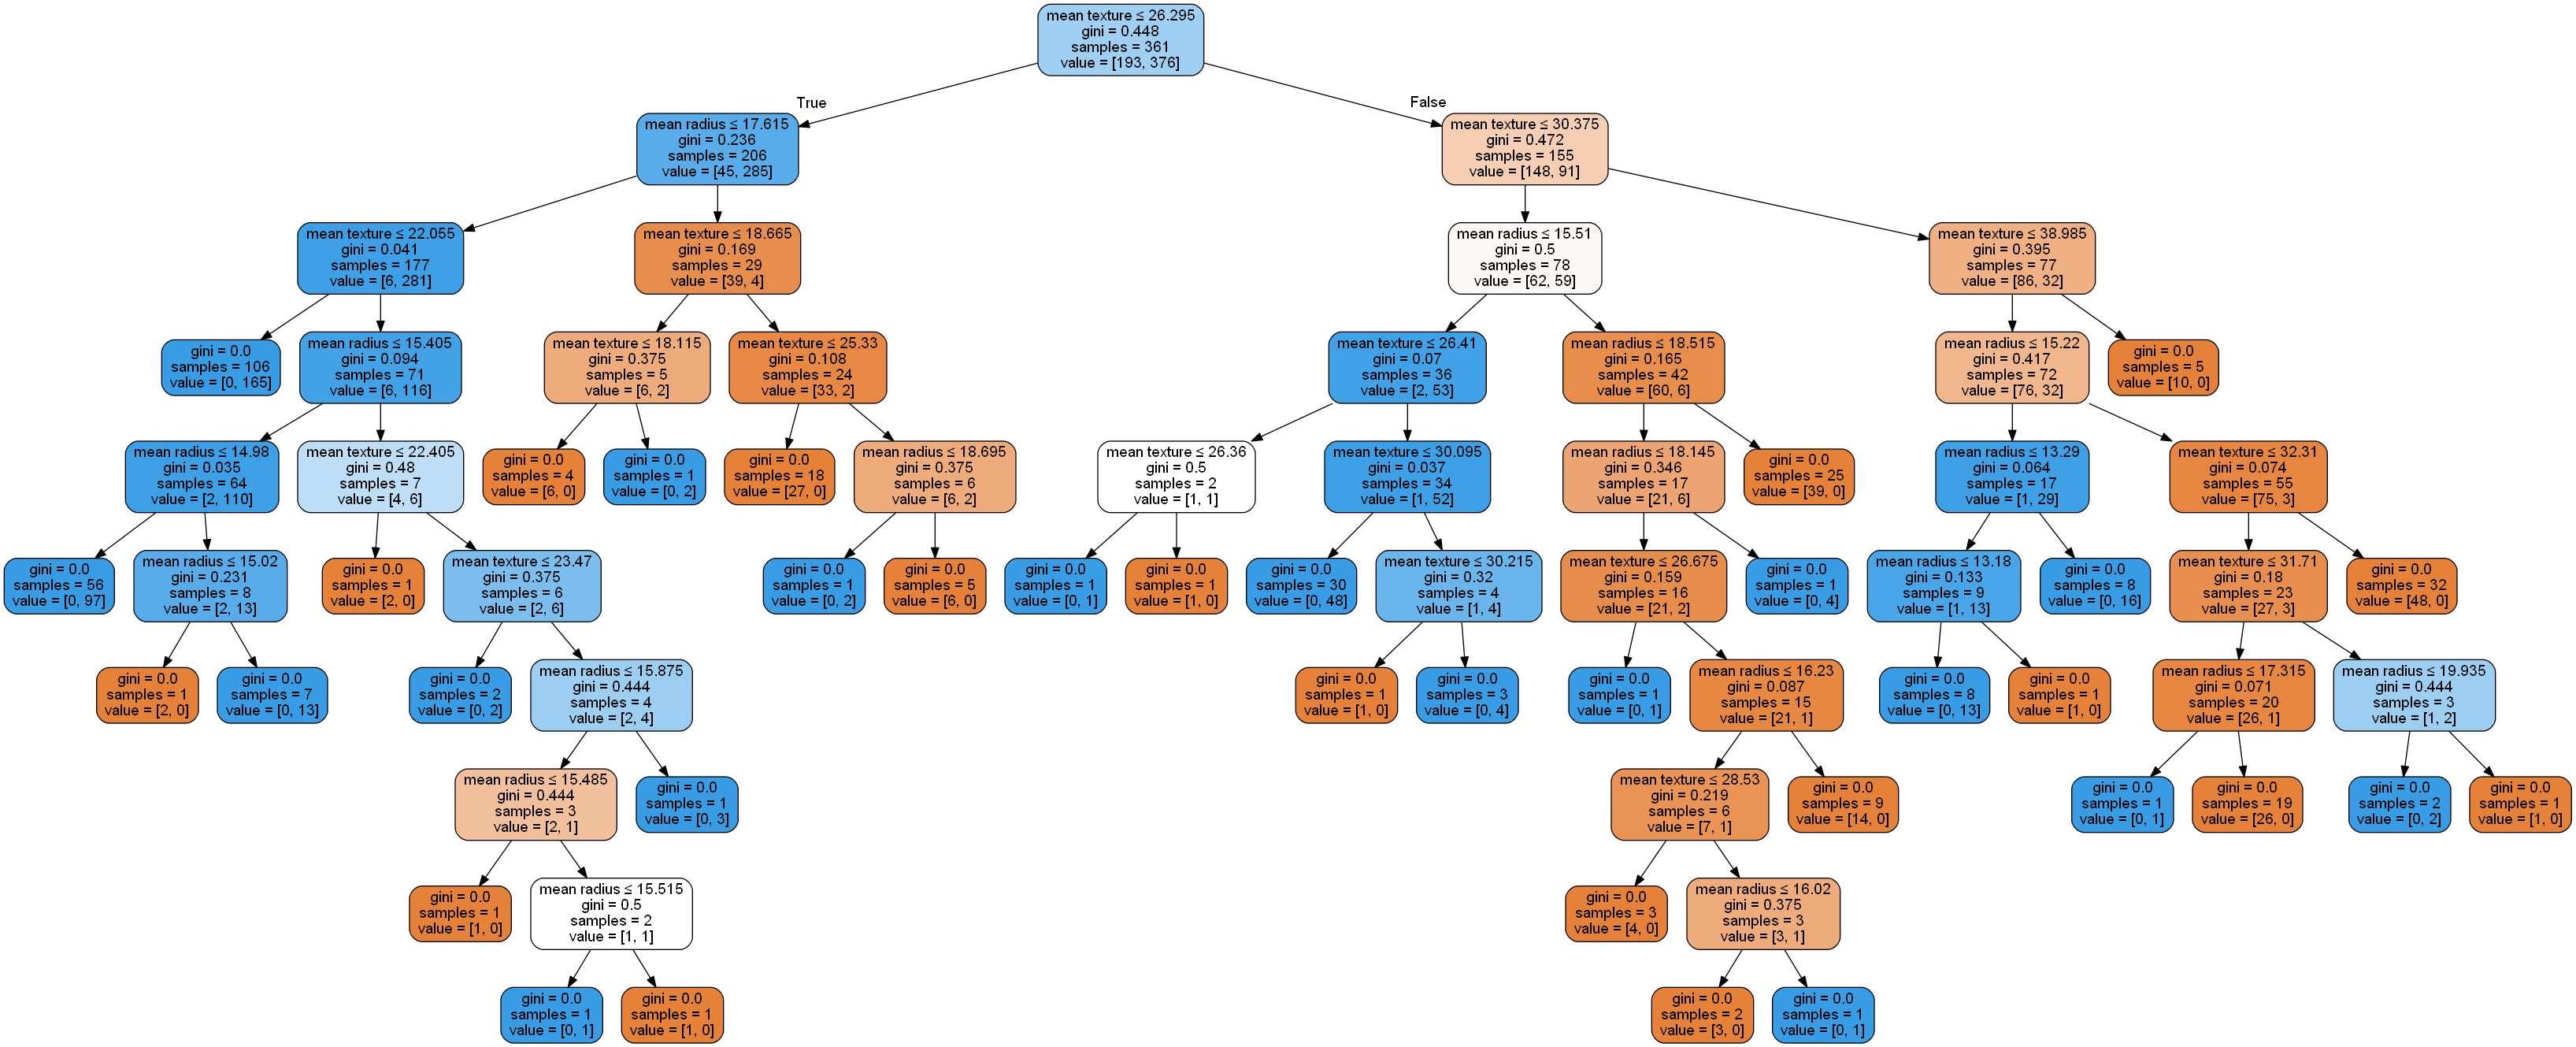

In [15]:
Image(get_png_tree(tree1.estimators_[2], breast.feature_names[:2]), width="1500")

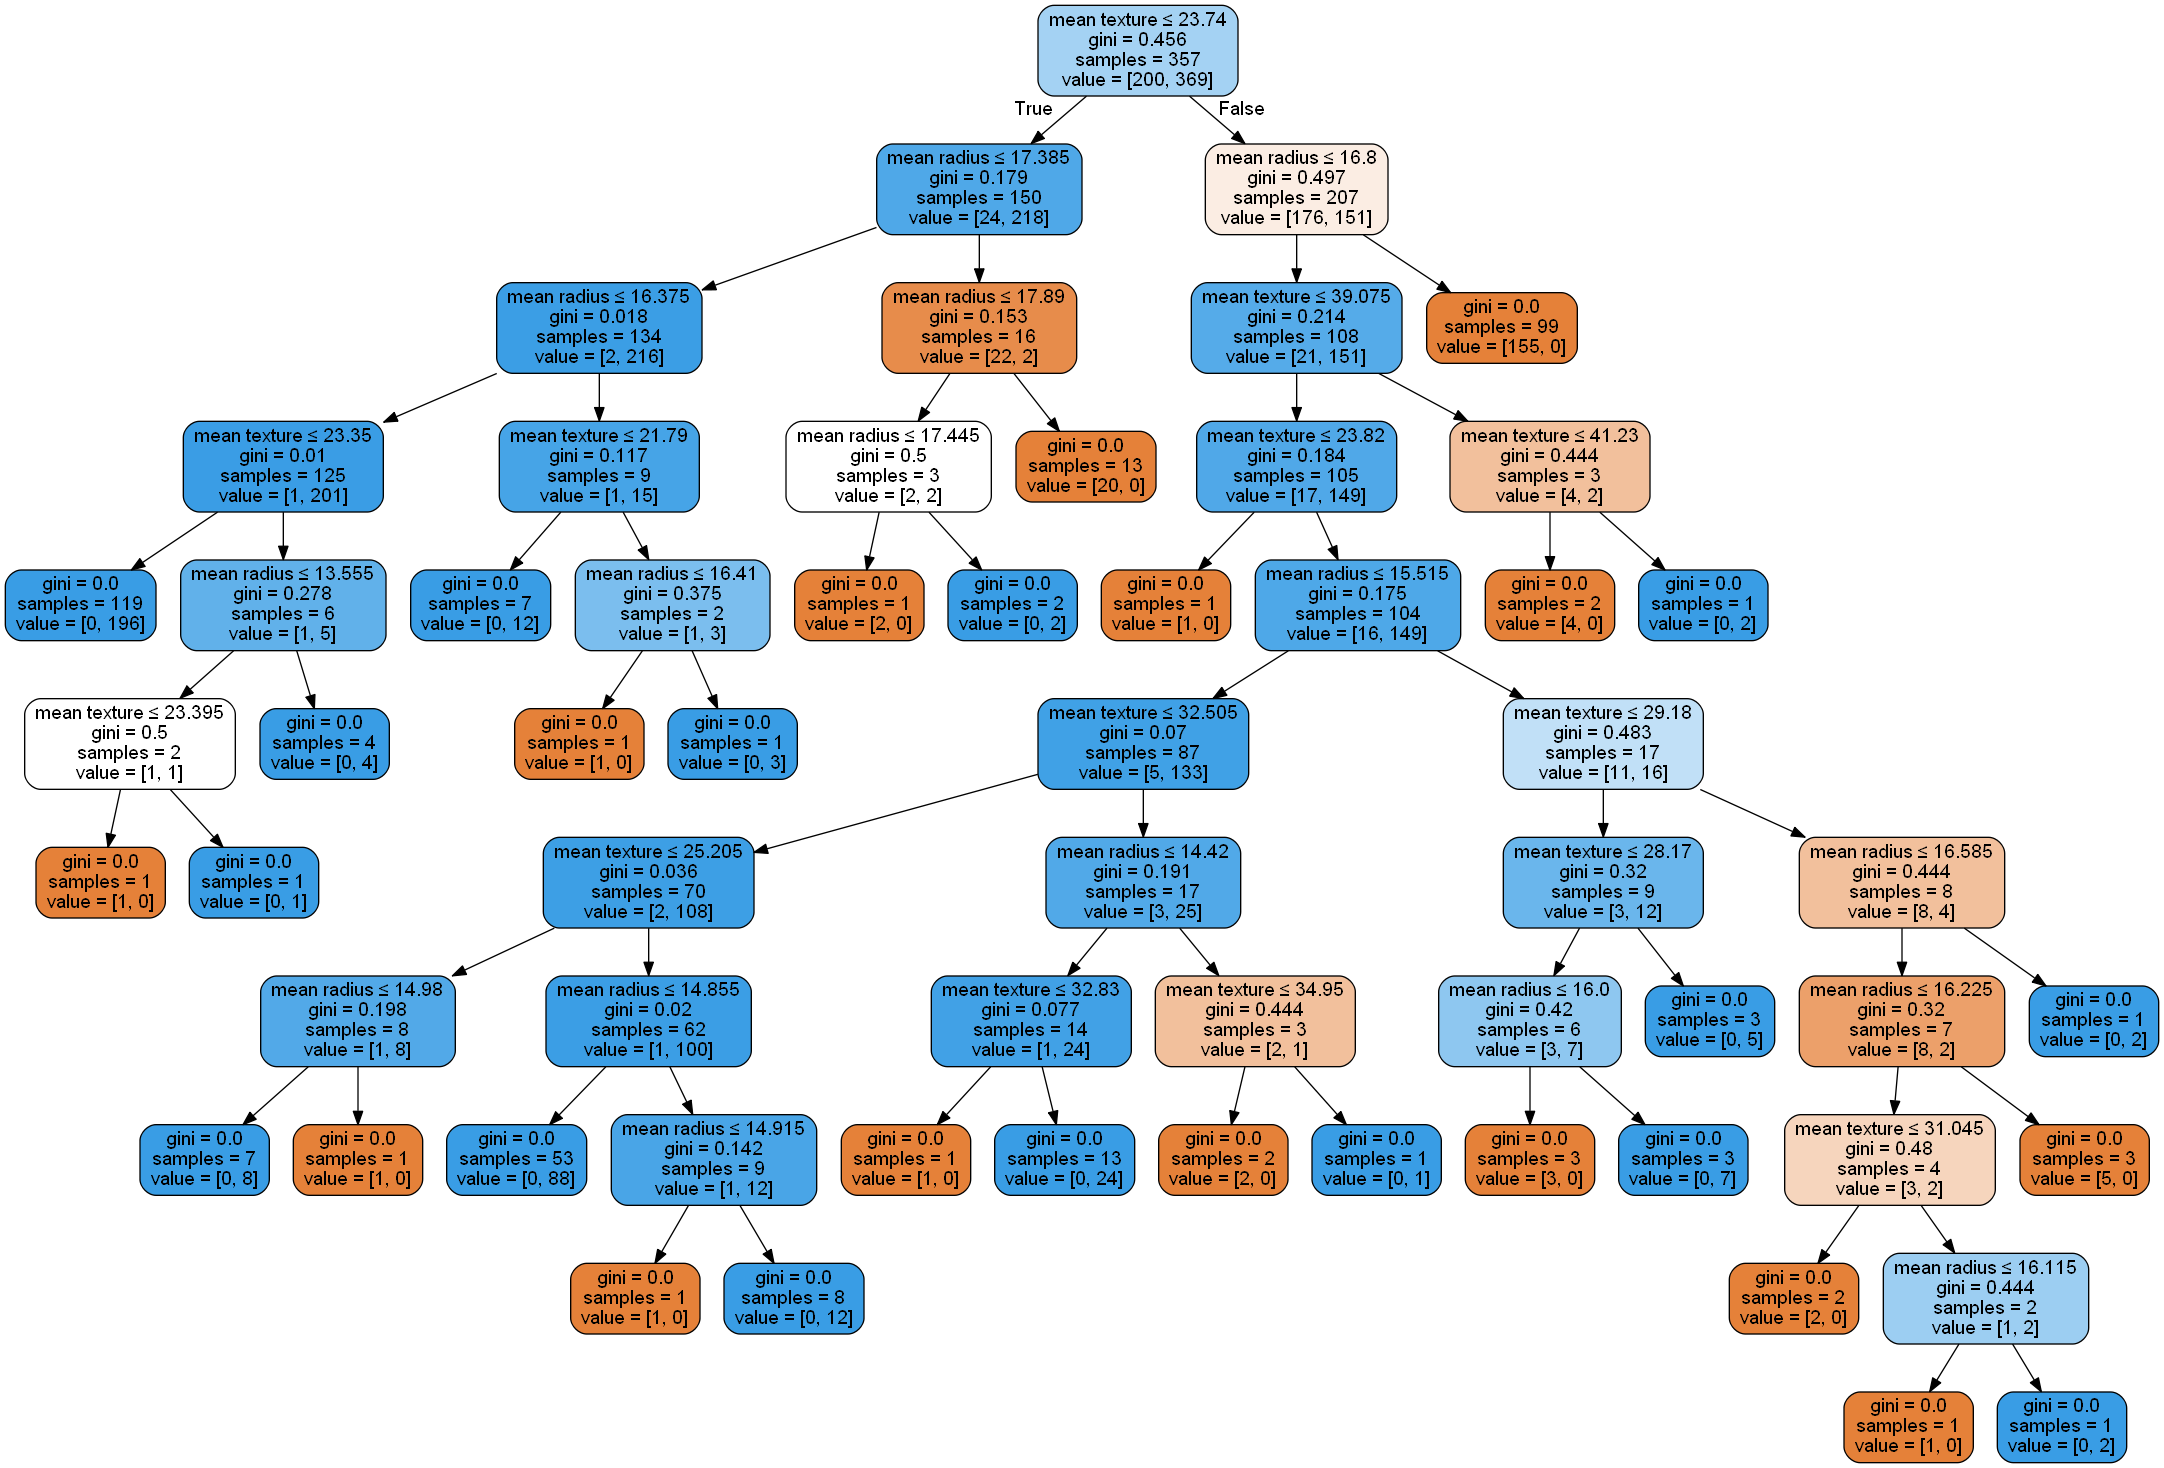

In [16]:
Image(get_png_tree(tree1.estimators_[3], breast.feature_names[:2]), width="1500")

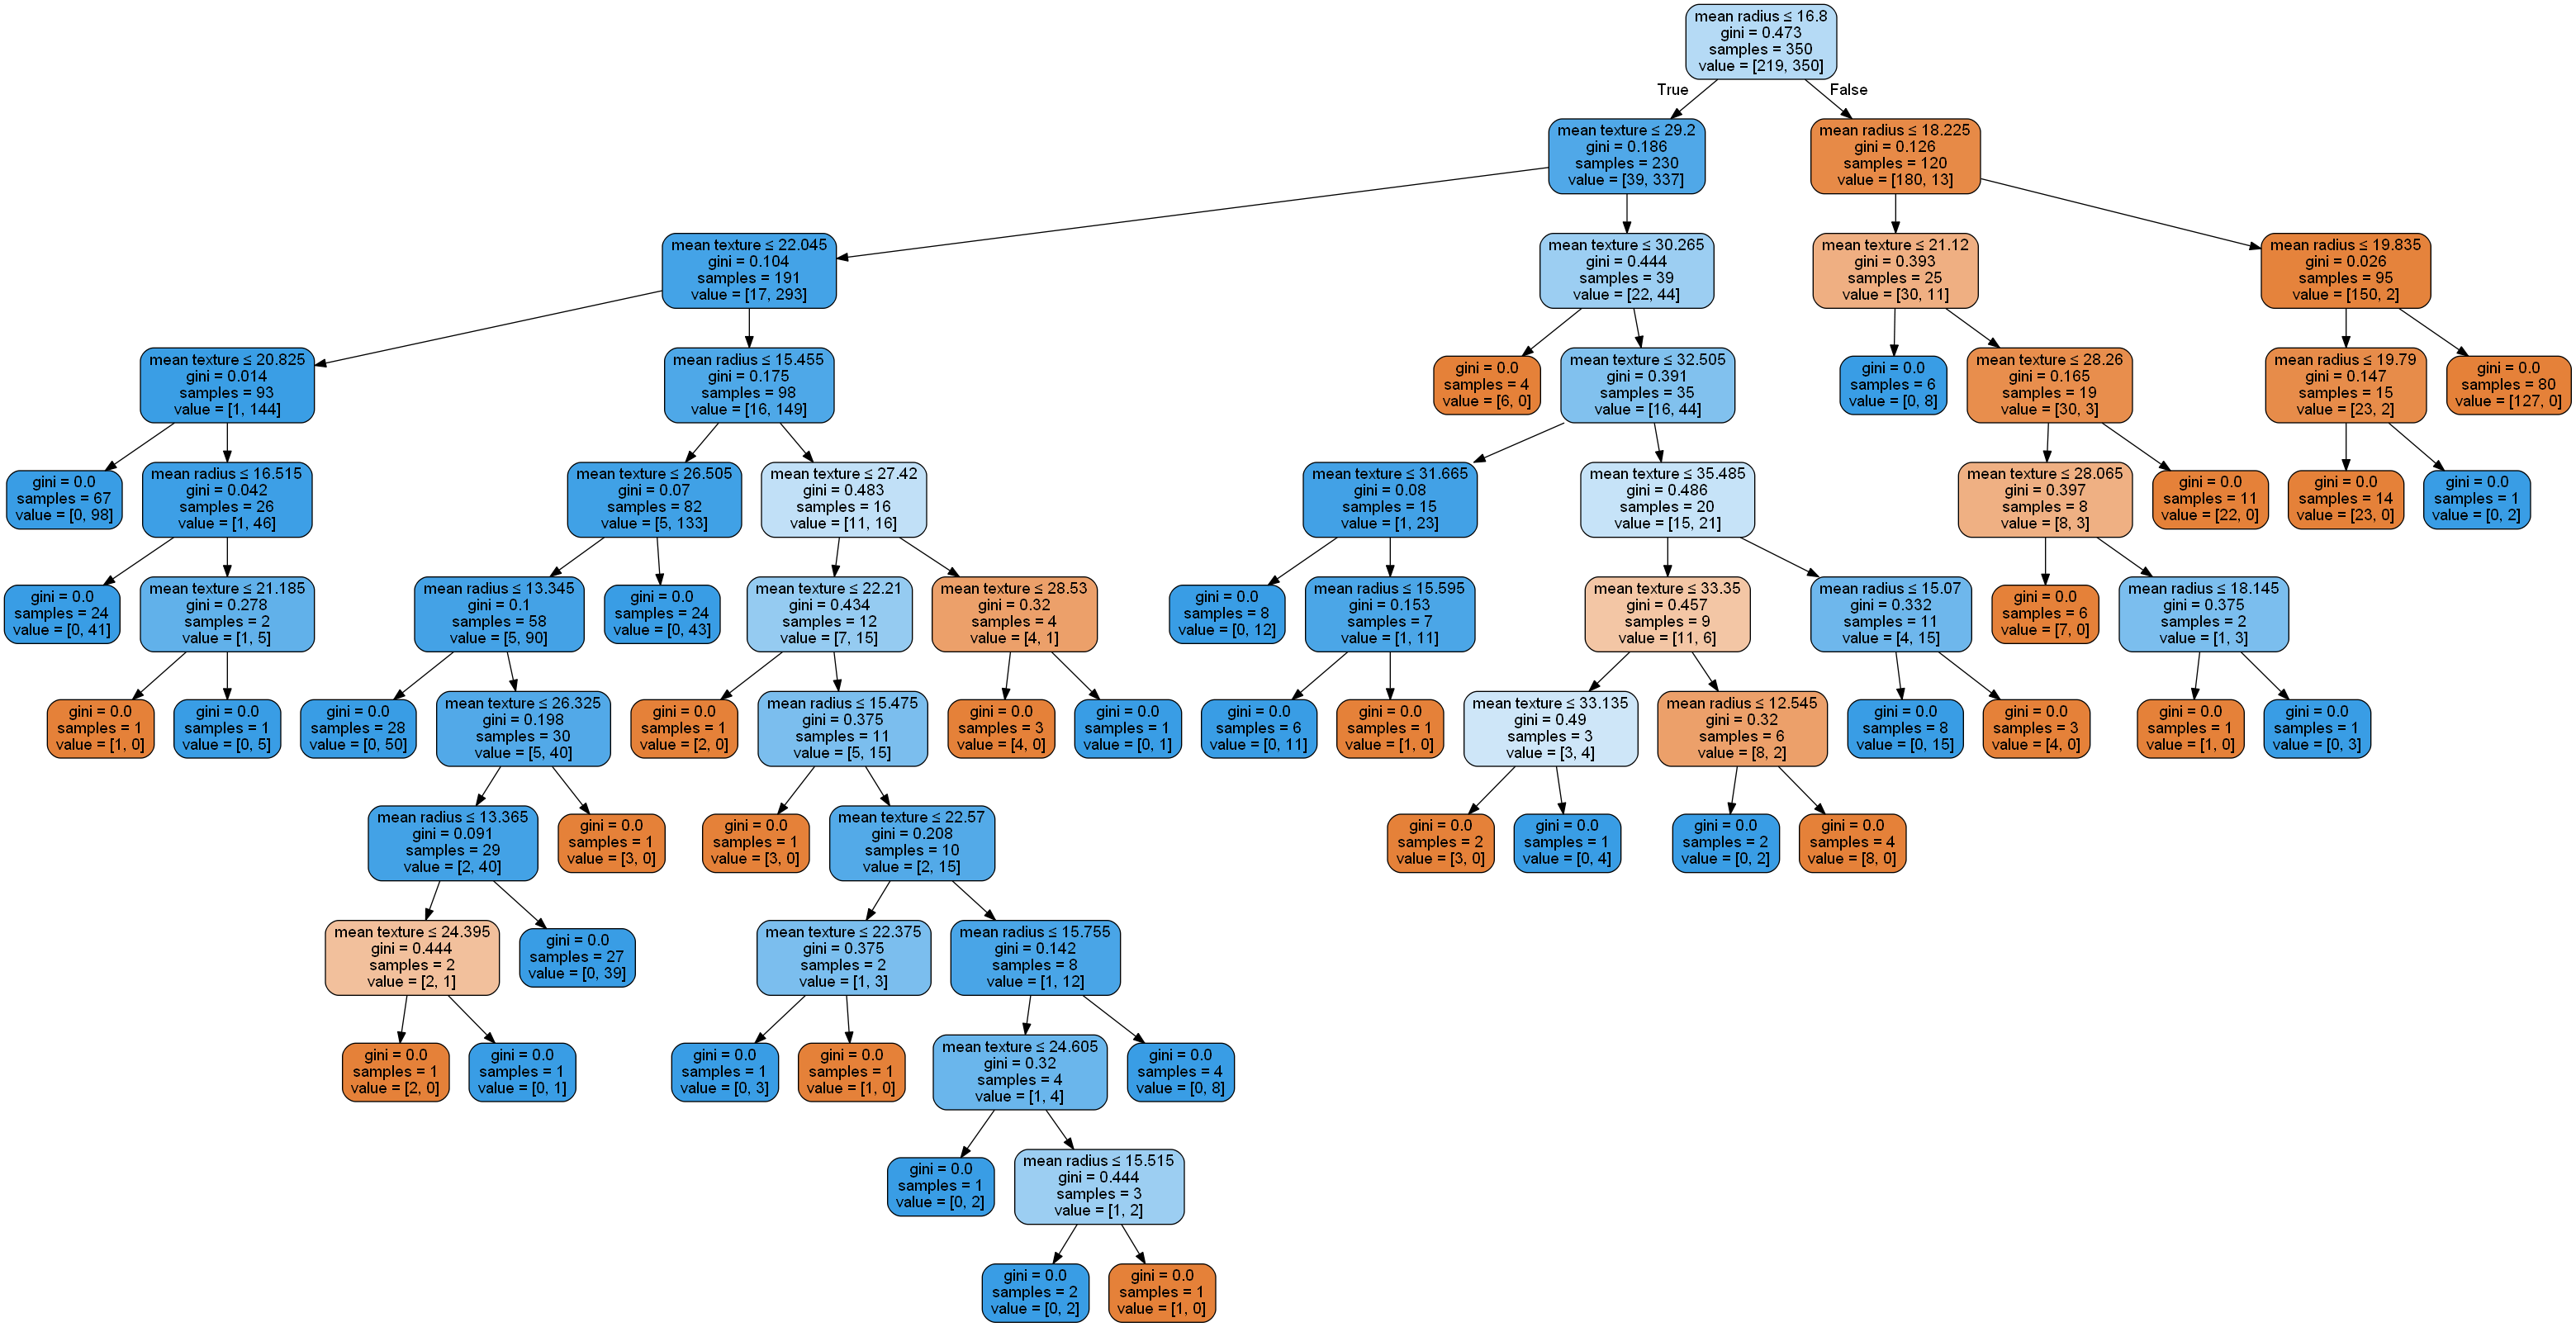

In [17]:
Image(get_png_tree(tree1.estimators_[4], breast.feature_names[:2]), width="1500")

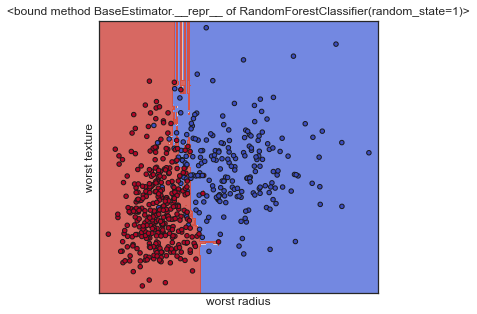

In [18]:
plot_cl(RandomForestClassifier(random_state=1))

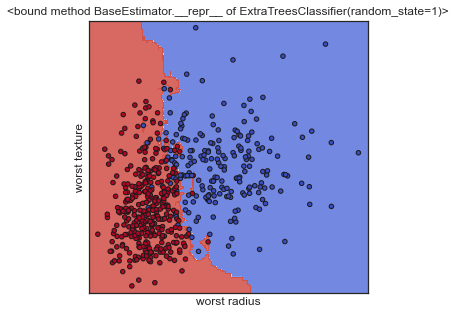

In [19]:
plot_cl(ExtraTreesClassifier(random_state=1))

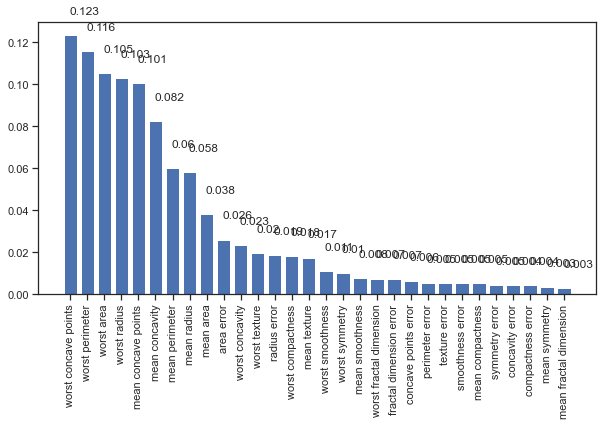

In [20]:
# Важность признаков
breast_x_ds = pd.DataFrame(data=breast['data'], columns=breast['feature_names'])
breast_rf_cl = RandomForestClassifier(random_state=1)
breast_rf_cl.fit(breast_x_ds, breast.target)
_,_ = draw_feature_importances(breast_rf_cl, breast_x_ds)

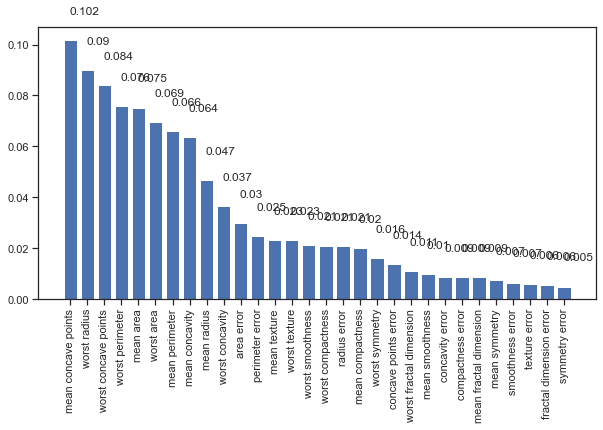

In [21]:
breast_xtree_cl = ExtraTreesClassifier(random_state=1)
breast_xtree_cl.fit(breast_x_ds, breast.target)
_, _ = draw_feature_importances(breast_xtree_cl, breast_x_ds)

## Градиентный бустинг

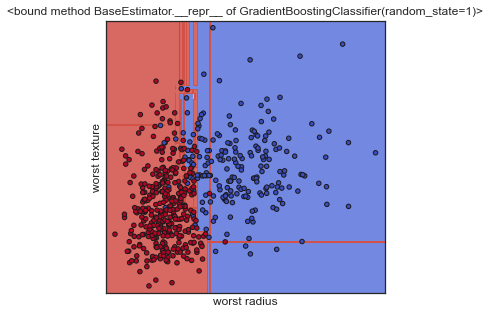

In [22]:
plot_cl(GradientBoostingClassifier(random_state=1))

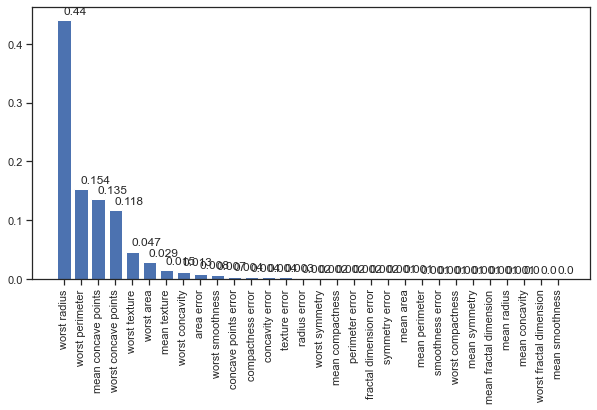

In [23]:
# Важность признаков
breast_gb_cl = GradientBoostingClassifier(random_state=1)
breast_gb_cl.fit(breast_x_ds, breast.target)
_,_ = draw_feature_importances(breast_gb_cl, breast_x_ds)

## Качество моделей с помощью двух подходящих для задачи метрик. Сравнение качеств полученных моделей.

**В качестве метрик для решения задачи классификации  будем использовать:**

- Метрика precision: $precision = \frac{TP}{TP+FP}$
- Метрика recall (полнота): $recall = \frac{TP}{TP+FN}$

In [24]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,4)), color='white')
    plt.show()

In [25]:
# Качество отдельных моделей
def val_mae(model, array_mae_ac, array_mae_pr, array_mae_re):
    model.fit(breast_X_train, breast_y_train)
    pred_breast_y_test = model.predict(breast_X_test)
    result = accuracy_score(breast_y_test, pred_breast_y_test)
    result1 = precision_score(breast_y_test, pred_breast_y_test)
    result2 = recall_score(breast_y_test, pred_breast_y_test)
    print(model)
    print('accuracy_score={}'.format(result))
    print('precision_score={}'.format(result1))
    print('recall_score={}'.format(result2))
    array_mae_ac += [result]
    array_mae_pr += [result1]
    array_mae_re += [result2]

In [26]:
array_labels = ['RandomForestClassifier','ExtraTreesClassifier', 'GradientBoostingClassifier']

In [27]:
array_mae_ac =[]
array_mae_pr =[]
array_mae_re =[]
# Точность на отдельных моделях
for model in [
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    GradientBoostingClassifier()
]:
    val_mae(model, array_mae_ac, array_mae_pr, array_mae_re)
    print('==========================')
    print()

RandomForestClassifier()
accuracy_score=0.9368421052631579
precision_score=0.9505494505494505
recall_score=0.9505494505494505

ExtraTreesClassifier()
accuracy_score=0.9368421052631579
precision_score=0.9456521739130435
recall_score=0.9560439560439561

GradientBoostingClassifier()
accuracy_score=0.9263157894736842
precision_score=0.96
recall_score=0.9230769230769231



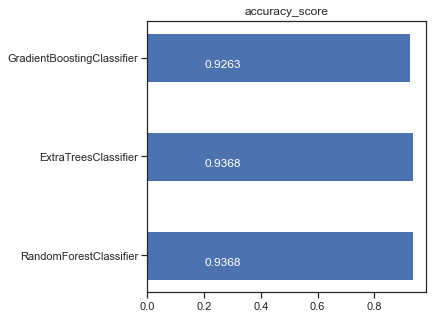

In [28]:
# Визуализация результатов
vis_models_quality(array_mae_ac, array_labels, 'accuracy_score')

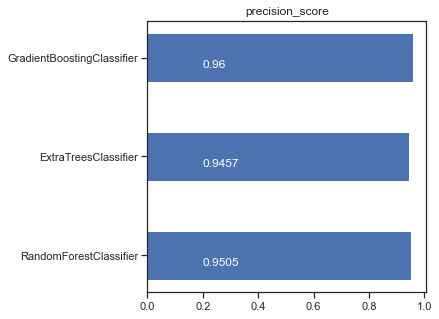

In [29]:
# Визуализация результатов
vis_models_quality(array_mae_pr, array_labels, 'precision_score')

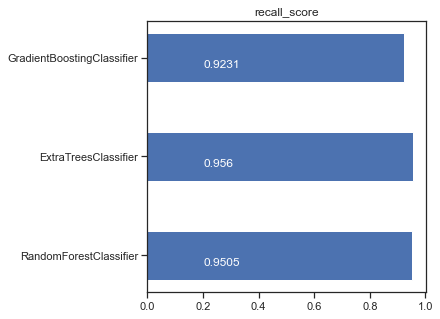

In [30]:
# Визуализация результатов
vis_models_quality(array_mae_re, array_labels, 'recall_score')